In [267]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow.keras.backend as K 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from math import sqrt

### 1. read file

In [268]:
data = pd.read_csv("preprocessing_csv/lstm_24group_1619.csv")
team = list(data.T_ID.unique())

data = pd.concat([data, pd.get_dummies(data.T_ID)], axis = 1)
# data.drop(["T_ID"], axis = 1, inplace = True)

In [269]:
train_data = data[data["IDX"] != 6]
test_data = data[data["IDX"] > 4]

###  2. shift window 생성

In [270]:
def shift_window_pct(df, team, window_size):
    res = pd.DataFrame([])
    
    for y in [2016,2017,2018,2019]:
        tmp = df[df["YEAR"]==y]
        
        for t in team:
            tmp2 = tmp[tmp["T_ID"]==t]
            for s in range(1, window_size+1):
                tmp2.loc[:,'shift_{}'.format(s)] = tmp2.loc[:,'PCT'].shift(s)

            res = pd.concat([res, tmp2], axis=0)

    return res

In [271]:
w_size = 1
train_df = shift_window_pct(train_data, team, w_size)
test_df = shift_window_pct(test_data, team, w_size)

# train_df = pd.DataFrame([])

# for y in [2016,2017,2018,2019]:
    
#     for t in team:
#         tmp_train = train_data[train_data["T_ID"]==t]
#         for s in range(1, 2):
#             tmp_train.loc[:,'shift_{}'.format(s)] = tmp_train.loc[:,'PCT'].shift(s)

#         train_df = pd.concat([train_df, tmp_train], axis=0)

# test_df = pd.DataFrame([])
# for t in team:
#     tmp_test = test_data[test_data["T_ID"]==t]
#     for s in range(1, 2):
#         tmp_test.loc[:,'shift_{}'.format(s)] = tmp_test.loc[:,'PCT'].shift(s)
    
#     test_df = pd.concat([test_df, tmp_test], axis=0)


c:\users\julia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\julia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [272]:
train_df.head(10)

,T_ID,YEAR,PCT,IDX,HEADER_NO,era,avg,vs_era,vs_avg,vs_HH,...,HT,KT,LG,LT,NC,OB,SK,SS,WO,shift_1
0,LG,2016,0.500000,1,0,5.358453,0.253317,4.555222,0.298349,4,...,0,0,1,0,0,0,0,0,0,NaN
1,LG,2016,0.478261,2,0,4.715603,0.291169,4.659483,0.274605,0,...,0,0,1,0,0,0,0,0,0,0.500000
2,LG,2016,0.375000,3,0,5.584768,0.305842,5.148837,0.288889,3,...,0,0,1,0,0,0,0,0,0,0.478261
3,LG,2016,0.458333,4,0,5.551402,0.297110,5.833333,0.288942,3,...,0,0,1,0,0,0,0,0,0,0.375000
4,LG,2016,0.583333,5,0,5.400000,0.294471,5.091926,0.286756,4,...,0,0,1,0,0,0,0,0,0,0.458333
6,NC,2016,0.541667,1,0,3.625592,0.268897,4.521127,0.239899,3,...,0,0,0,0,1,0,0,0,0,NaN
7,NC,2016,0.652174,2,0,4.479263,0.312354,6.750000,0.270983,2,...,0,0,0,0,1,0,0,0,0,0.541667
8,NC,2016,0.739130,3,0,5.059908,0.294798,6.560748,0.283863,2,...,0,0,0,0,1,0,0,0,0,0.652174
9,NC,2016,0.541667,4,0,5.057143,0.286241,5.537352,0.279323,3,...,0,0,0,0,1,0,0,0,0,0.739130
10,NC,2016,0.500000,5,0,5.086350,0.294611,5.602175,0.273723,4,...,0,0,0,0,1,0,0,0,0,0.541667


In [273]:
X_train = train_df.dropna().drop(['PCT','T_ID'], axis=1).reset_index(drop=True)
y_train = train_df.dropna()[['PCT']].reset_index(drop=True)

In [274]:
X_test = test_df.dropna().drop(['PCT','T_ID'], axis=1).reset_index(drop=True)
y_test = test_df.dropna()[['PCT']].reset_index(drop=True)

In [275]:
X_train.shape

(160, 90)

In [276]:
y_train.shape

(160, 1)

In [277]:
X_test.shape

(40, 90)

In [278]:
y_test.shape

(40, 1)

### 3. ndarray 변환

In [279]:
X_test

,YEAR,IDX,HEADER_NO,era,avg,vs_era,vs_avg,vs_HH,vs_HT,vs_KT,...,HT,KT,LG,LT,NC,OB,SK,SS,WO,shift_1
0,2016,6,0,3.649770,0.296069,4.993723,0.268530,2,3,2,...,0,0,1,0,0,0,0,0,0,0.583333
1,2016,6,3,3.575342,0.287440,4.309859,0.243932,2,1,3,...,0,0,0,0,1,0,0,0,0,0.500000
2,2016,6,0,6.314536,0.295455,4.422770,0.332943,3,5,0,...,0,1,0,0,0,0,0,0,0,0.333333
3,2016,6,0,5.704830,0.289941,4.939535,0.297461,3,4,2,...,0,0,0,0,0,0,0,0,1,0.625000
4,2016,6,0,4.710280,0.298225,5.816038,0.295318,3,0,4,...,0,0,0,0,0,1,0,0,0,0.666667
5,2016,6,0,5.258106,0.288575,4.813953,0.322014,0,3,3,...,0,0,0,0,0,0,0,0,0,0.500000
6,2016,6,0,5.144874,0.305263,5.341121,0.280340,3,4,1,...,0,0,0,0,0,0,1,0,0,0.458333
7,2016,6,0,5.849303,0.309893,5.724702,0.308789,2,0,5,...,0,0,0,1,0,0,0,0,0,0.375000
8,2016,6,3,5.400000,0.283863,5.425234,0.294393,2,2,1,...,0,0,0,0,0,0,0,1,0,0.500000
9,2016,6,0,4.120820,0.256739,3.844931,0.271144,3,0,5,...,1,0,0,0,0,0,0,0,0,0.500000


In [280]:
X_train_v = X_train.values
y_train_v = y_train.values

In [281]:
X_test_v = X_test.values
y_test_v = y_test.values

In [282]:
print(X_train_v.shape)
print(X_train_v)
print(y_train_v.shape)
print(y_train_v)

(160, 90)
[[2.01600000e+03 2.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.00000000e-01]
 [2.01600000e+03 3.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 4.78260870e-01]
 [2.01600000e+03 4.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.75000000e-01]
 ...
 [2.01900000e+03 3.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.33333333e-01]
 [2.01900000e+03 4.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.41666667e-01]
 [2.01900000e+03 5.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 4.16666667e-01]]
(160, 1)
[[0.47826087]
 [0.375     ]
 [0.45833333]
 [0.58333333]
 [0.65217391]
 [0.73913043]
 [0.54166667]
 [0.5       ]
 [0.36363636]
 [0.41666667]
 [0.375     ]
 [0.33333333]
 [0.58333333]
 [0.5       ]
 [0.66666667]
 [0.625     ]
 [0.70833333]
 [0.66666667]
 [0.45833333]
 [0.66666667]
 [0.39130435]
 [0.52173913]
 [0.60869565]
 [0.5       ]
 [0.41666667]
 [0.45833333]
 [0.45833333]
 [0

### 4. 최종 train 의 X 만들기
* 3차원 데이터여야하며 각각의 차원은 (size, timestep, feature)

In [283]:
X_train_v.shape

(160, 90)

In [284]:
X_train_t = X_train_v.reshape(X_train_v.shape[0],1,90)

In [285]:
X_test_t = X_test_v.reshape(X_test_v.shape[0],1,90)

In [286]:
X_train_t.shape, X_test_t.shape, 

((160, 1, 90), (40, 1, 90))

### 5. LSTM 모델 생성
https://yjjo.tistory.com/32
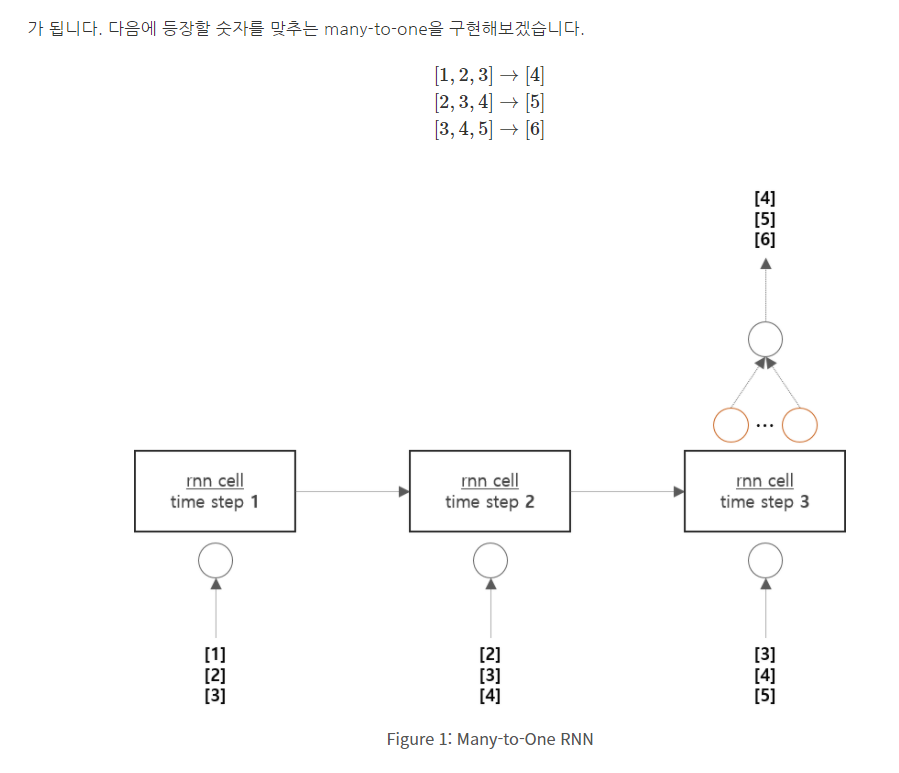

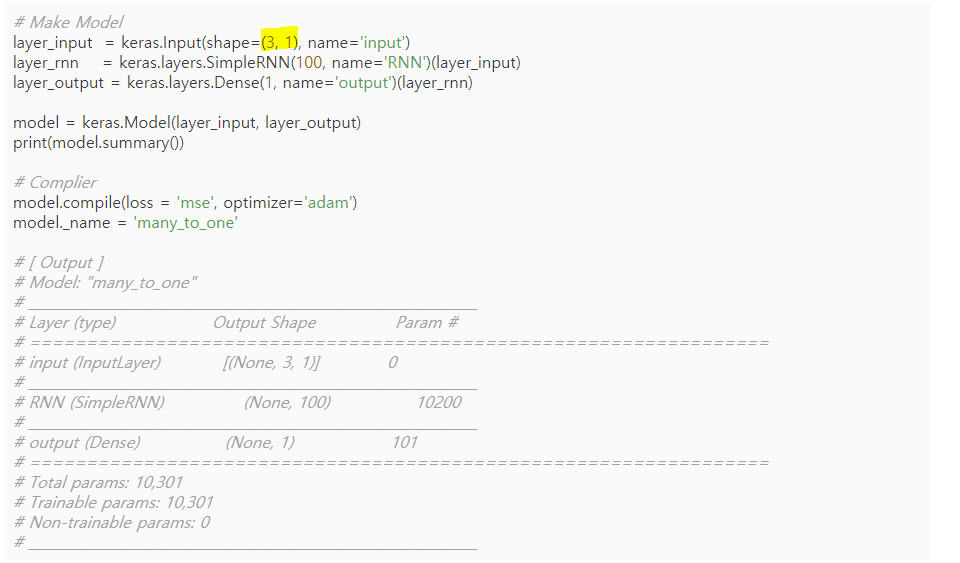

In [287]:
K.clear_session() 

model = Sequential()

model.add(LSTM(500,input_shape = (1,90))) # (timestep, feature)
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500)               1182000   
_________________________________________________________________
dense (Dense)                (None, 1)                 501       
Total params: 1,182,501
Trainable params: 1,182,501
Non-trainable params: 0
_________________________________________________________________


In [288]:
early_stop = EarlyStopping(monitor='loss', mode = 'min', patience=2, verbose=1)


hist1 = model.fit(X_train_t, y_train_v, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Train on 160 samples
Epoch 1/100
160/160 [==============================] - 4s 25ms/sample - loss: 0.0193 - mae: 0.1097
Epoch 2/100
160/160 [==============================] - 1s 8ms/sample - loss: 0.0182 - mae: 0.1082
Epoch 3/100
160/160 [==============================] - 1s 8ms/sample - loss: 0.0205 - mae: 0.1143
Epoch 4/100
160/160 [==============================] - 1s 8ms/sample - loss: 0.0183 - mae: 0.1096
Epoch 00004: early stopping


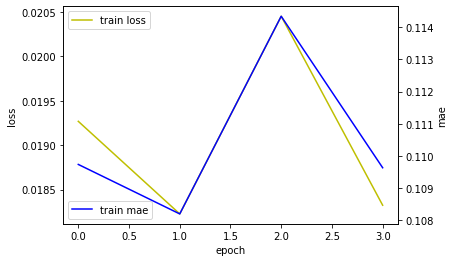

In [289]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist1.history['loss'], 'y', label='train loss')

acc_ax.plot(hist1.history['mae'], 'b', label='train mae')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mae')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 성능확인

In [290]:
X_test_t

array([[[2.01600000e+03, 6.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 5.83333333e-01]],

       [[2.01600000e+03, 6.00000000e+00, 3.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 5.00000000e-01]],

       [[2.01600000e+03, 6.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.33333333e-01]],

       ...,

       [[2.01900000e+03, 6.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.91304348e-01]],

       [[2.01900000e+03, 6.00000000e+00, 0.00000000e+00, ...,
         1.00000000e+00, 0.00000000e+00, 3.75000000e-01]],

       [[2.01900000e+03, 6.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 4.78260870e-01]]])

In [291]:
y_pred = model.predict(X_test_t)

In [292]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.510839,0.608696
1,0.510831,0.565217
2,0.510832,0.291667
3,0.510836,0.375000
4,0.510839,0.666667
5,0.510832,0.500000
6,0.510838,0.458333
7,0.510831,0.500000
8,0.510826,0.500000
9,0.510837,0.458333


In [293]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.10630928757835852